#顯示GPU

In [ ]:
!nvidia-smi

Sun Mar 28 10:40:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#環境建置：

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pwd
%cd /content/drive/My Drive/FakeNewsNet/
!pip install transformers
!pip install nltk
import nltk
nltk.download("popular")

import pandas as pd
import numpy as np
subject="politifact"
path = "Bert"

Mounted at /content/drive
/content
/content/drive/My Drive/FakeNewsNet
     |████████████████████████████████| 2.0MB 5.6MB/s 
     |████████████████████████████████| 890kB 17.4MB/s 
     |████████████████████████████████| 3.2MB 28.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=ff892f8f76777a58a6e1561d28e969086abc4672a43b180b2e1d5cfa6257c34f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenbe

#預處理：

In [ ]:
#每個句子分開來tokenize
import nltk
from transformers import BertTokenizerFast
subject="politifact"
data_raw = pd.read_csv(subject+".csv")

#------------------------------------------------------------------------------- Preprocess -------------------------------------------------------------------

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

total_rows = data_raw.shape[0]
token_data = pd.DataFrame({"title":[],"text":[],"tag":[],"title_len":[],"text_len":[]})

for i,temp in data_raw.iterrows():
  if(i%10==0):
    print("{} : {} / {}".format(i/total_rows,i,total_rows))
  
  title_token = []
  if pd.notna(temp["title"]):
    title_sentences = nltk.sent_tokenize(temp["title"])
    title_token = tokenizer(title_sentences,truncation=True,padding=True,max_length=50)["input_ids"]

  text_token = []
  if pd.notna(temp["text"]):
    text_sentences = nltk.sent_tokenize(temp["text"])
    text_token = tokenizer(text_sentences,truncation=True,padding=True,max_length=50)["input_ids"]

  token_data = token_data.append({"title":title_token,"text":text_token,"tag":temp["label"],"title_len":len(title_token),"text_len":len(text_token)},ignore_index = True)

print(token_data)
token_data.to_csv(subject+"_token_data_bert.csv",index=False)

0.0 : 0 / 1021
0.009794319294809012 : 10 / 1021
0.019588638589618023 : 20 / 1021
0.029382957884427033 : 30 / 1021
0.039177277179236046 : 40 / 1021
0.04897159647404505 : 50 / 1021
0.058765915768854066 : 60 / 1021
0.06856023506366307 : 70 / 1021
0.07835455435847209 : 80 / 1021
0.0881488736532811 : 90 / 1021
0.0979431929480901 : 100 / 1021
0.10773751224289912 : 110 / 1021
0.11753183153770813 : 120 / 1021
0.12732615083251714 : 130 / 1021
0.13712047012732614 : 140 / 1021
0.14691478942213515 : 150 / 1021
0.15670910871694418 : 160 / 1021
0.1665034280117532 : 170 / 1021
0.1762977473065622 : 180 / 1021
0.1860920666013712 : 190 / 1021
0.1958863858961802 : 200 / 1021
0.20568070519098922 : 210 / 1021
0.21547502448579825 : 220 / 1021
0.22526934378060726 : 230 / 1021
0.23506366307541626 : 240 / 1021
0.24485798237022527 : 250 / 1021
0.2546523016650343 : 260 / 1021
0.2644466209598433 : 270 / 1021
0.2742409402546523 : 280 / 1021
0.2840352595494613 : 290 / 1021
0.2938295788442703 : 300 / 1021
0.30362389

In [ ]:
#tokenize到接近512直接從512的下一句tokenize(無重疊)
import nltk
from transformers import BertTokenizerFast
from sklearn.preprocessing import OneHotEncoder
subject="politifact"
data_raw = pd.read_csv(subject+".csv")

#------------------------------------------------------------------------------- Preprocess -------------------------------------------------------------------
def sentence_concatenate(tokens):
  new_token = []
  buffer = []
  for i,token in enumerate(tokens):
    if i==0:
      buffer = token
    elif len(buffer)+len(token)<=512:
      buffer+=token[1:]
    else:
      buffer+=[0]*(512-len(buffer))
      new_token.append(buffer)
      buffer = token
  buffer+=[0]*(512-len(buffer))
  new_token.append(buffer)
  return new_token

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

total_rows = data_raw.shape[0]
token_data = pd.DataFrame({"title":[],"text":[],"tag":[],"title_len":[],"text_len":[]})

for i,temp in data_raw.iterrows():
  if(i%10==0):
    print("{} : {} / {}".format(i/total_rows,i,total_rows))
  
  title_token = []
  if pd.notna(temp["title"]):
    title_sentences = nltk.sent_tokenize(temp["title"])
    for sentence in title_sentences:
      title_token.append(tokenizer.encode(sentence,truncation=True,max_length=512))
  title_token = sentence_concatenate(title_token)
  
  text_token = []
  if pd.notna(temp["text"]):
    text_sentences = nltk.sent_tokenize(temp["text"])
    for sentence in text_sentences:
      text_token.append(tokenizer.encode(sentence,truncation=True,max_length=512))
  text_token = sentence_concatenate(text_token)

  token_data = token_data.append({"title":title_token,"text":text_token,"tag":temp["label"],"title_len":len(title_token),"text_len":len(text_token)},ignore_index = True)
  
print(token_data)
token_data.to_csv(subject+"_token_data_bert_concate.csv",index=False)

#進度顯示用函式：

In [ ]:
import time
import math
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)
def timeSince(since, percent):
  now = time.time()
  s = now - since
  if percent!=0:
    es = s / (percent)
    rs = es - s
    return "%s (- %s)" % (asMinutes(s), asMinutes(rs))
  else:
    return "%s (- INF)" % (asMinutes(s))

def progress(start,cur , total_len, loss):
  print("{} ({}%)\nloss = {}".format(
    timeSince(start,cur / total_len),
    (cur / total_len)* 100,
    loss
    )
  )

#訓練模型：


In [ ]:
#------------------------------------------------------------------------------- training shits -------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel

GRU_HIDDEN_SIZE=64

# Bert-Embedding
class BiGRU(nn.Module):
  def __init__(self):
    super(BiGRU, self).__init__()
    self.embedding = BertModel.from_pretrained('bert-base-uncased')
    self.gru = nn.GRU(
        input_size=768,
        hidden_size=GRU_HIDDEN_SIZE,
        dropout=0.3,
        num_layers=1,
        bidirectional=True,
        # batch_first=True,
    )

  def forward(self, tokens, masks=None):
    # BERT
    # with torch.no_grad():
    embedded = self.embedding(tokens, attention_mask=masks)["last_hidden_state"]
    cls_vector = embedded[:,0,:]

    # GRU
    _, hidden = self.gru(cls_vector)

    return hidden[-1]

class FakeNewsDetection(nn.Module):
  def __init__(self):
    super(FakeNewsDetection,self).__init__()
    self.bertEmbed = BiGRU()
    self.FC_1 = nn.Linear(GRU_HIDDEN_SIZE,1)

  
  def forward(self, titles, texts):
    count = 0
    titleEmbed = torch.zeros(GRU_HIDDEN_SIZE).to(device)
    textEmbed = torch.zeros(GRU_HIDDEN_SIZE).to(device)
    newsEmbed = torch.zeros(GRU_HIDDEN_SIZE).to(device)
    if len(titles)!=0:
      titleEmbed = self.bertEmbed(titles)
      count+=1
    if len(texts)!=0:
      textEmbed = self.bertEmbed(texts)
      count+=1
    if count!=0:
      newsEmbed = (titleEmbed+textEmbed)/count
    
    output = self.FC_1(newsEmbed.to(device))

    return F.sigmoid(output)


#訓練用函式(輸入一篇新聞)：

In [ ]:
def train(train_model,X,y,optimizer,loss_func):
  optimizer.zero_grad()
  predict = train_model(torch.tensor(eval(X[0])).to(device),torch.tensor(eval(X[1])).to(device))
  loss = loss_func(predict.view(1), torch.tensor([y]).to(device))
  # print("predict: {}\nans:     {}\n loss: {}".format(predict,torch.tensor([y]),loss))
  loss.backward()
  optimizer.step()
  return predict,loss.item()

#訓練前讀檔：

In [ ]:
from sklearn.model_selection import KFold
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
token_data_read_pd = pd.read_csv(path+"/"+subject+"_token_data_bert.csv")
token_data_read_pd = token_data_read_pd[token_data_read_pd["text_len"]<250]
token_data_read = token_data_read_pd.to_numpy() 

#訓練：

In [ ]:
title_len = [0, 0, 0]
text_len = [0, 0, 0]
for data in token_data_read:
  if data[-2]<=3:
    title_len[0]+=1
  elif data[-2]<=5:
    title_len[1]+=1
  else:
    title_len[2]+=1
  
  if data[-1]<=50:
    text_len[0]+=1
  elif data[-1]<=300:
    text_len[1]+=1
  else:
    #print(data[-1])
    text_len[2]+=1
print(title_len)
print(text_len)

[939, 0, 0]
[845, 94, 0]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0m 2s (- INF) (0.0%)
loss = 0.7220312356948853
0m 8s (- 59m 39s) (0.2366863905325444%)
loss = 1.1156151294708252
0m 13s (- 46m 58s) (0.4733727810650888%)
loss = 0.28657785058021545
0m 17s (- 41m 25s) (0.7100591715976331%)
loss = 0.8011062741279602
0m 21s (- 38m 7s) (0.9467455621301776%)
loss = 1.3054008483886719
0m 28s (- 40m 19s) (1.183431952662722%)
loss = 0.5242797136306763
0m 32s (- 37m 9s) (1.4201183431952662%)
loss = 0.9475170373916626
0m 39s (- 39m 2s) (1.6568047337278107%)
loss = 0.650314450263977
0m 47s (- 41m 17s) (1.8934911242603552%)
loss = 0.26239871978759766
0m 50s (- 39m 2s) (2.130177514792899%)
loss = 0.759981095790863
0m 57s (- 39m 47s) (2.366863905325444%)
loss = 0.7677631378173828
1m 5s (- 40m 37s) (2.603550295857988%)
loss = 0.6296190619468689
1m 10s (- 39m 56s) (2.8402366863905324%)
loss = 0.8077743053436279
1m 13s (- 38m 26s) (3.076923076923077%)
loss = 0.736964762210846
1m 16s (- 37m 16s) (3.3136094674556213%)
loss = 0.696183979511261
1m 21s (- 36m 40s) (3.550295

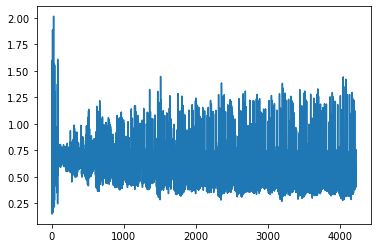

end


In [ ]:
import matplotlib.pyplot as plt

random_index = list(range(token_data_read.shape[0]))
np.random.shuffle(random_index)
f = open(path+'/model/random.txt', 'w')
for i in random_index:
  f.write(str(i)+"\n")
f.close()

confusion_matrix = [[0,0],[0,0]]
kf = KFold(n_splits=10, shuffle=False)
for train_index, test_index in kf.split(random_index):
  FND_model = FakeNewsDetection().to(device)
  loss_func = nn.BCELoss()
  optimizer = optim.Adam(FND_model.parameters(), lr=0.0001)

  FND_model.train()
  losses=[]
  EPOCH = 5
  cur = 0
  start = time.time()
  for epoch in range(EPOCH):
    for i in train_index:

      predict,loss = train(FND_model,token_data_read[random_index[i]][:2],float(token_data_read[random_index[i]][2]),optimizer,loss_func)
      losses.append(loss)
      
      #紀錄模型
      if cur%50==0:
        torch.save(FND_model, path+'/model/FND_model_{}.pt'.format(cur))

      if cur%10==0:
        progress(start,cur,train_index.shape[0]*EPOCH,loss)
      cur+=1
  plt.plot(range(len(losses)),losses)
  plt.savefig(path+'/model/loss.png')
  plt.show()

  break
print("end")

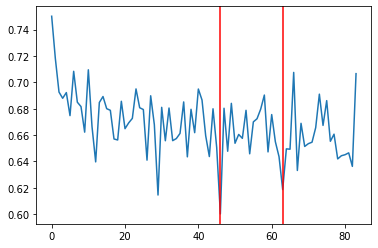

In [ ]:
plot_loss=[]
sum=0
for i,loss in enumerate(losses):
  sum+=loss
  if i%50==49:
    plot_loss.append(sum/50)
    sum=0
plt.plot(range(len(plot_loss)),plot_loss)
plt.axvline(x=46,color='r')
plt.axvline(x=63,color='r')
# plt.axvline(x=73,color='r')
# plt.ylim(0, 2)
plt.savefig(path+'/model/haha.png')
plt.show()

#evaluate用函式：

In [ ]:
def evaluate(eval_model,X,y,loss_func):
  with torch.no_grad():
    predict = eval_model(torch.tensor(eval(X[0])).to(device),torch.tensor(eval(X[1])).to(device))
    loss = loss_func(predict.view(1), torch.tensor([y]).to(device))
  return predict,loss.item()

#evaluate讀檔：

In [ ]:
token_data_read_pd = pd.read_csv(path+"/"+subject+"_token_data_bert.csv")
token_data_read_pd = token_data_read_pd[token_data_read_pd["text_len"]<250]
token_data_read = token_data_read_pd.to_numpy() 
f = open(path+'/model/random.txt', 'r')
random_index_read = [int(i) for i in list(f.read().split("\n")[:-1])]
f.close()

#training error:

In [ ]:
train_index=random_index_read[:int(len(random_index_read)*0.9)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
confusion_matrix = [[0,0],[0,0]]
eval_model = torch.load(path+"/model/FND_model_2300.pt")
eval_model.eval()
loss_func = nn.BCELoss()
EPOCH = 1
total_loss=0
cur_eval=0
THRESHOLD=0.5
start_eval = time.time()
for i in train_index:
  predict,loss = evaluate(eval_model,token_data_read[i][:-3],float(token_data_read[i][-3]),loss_func)
  total_loss+=loss
  confusion_matrix[int(token_data_read[i][-3])][predict>THRESHOLD]+=1

  if cur_eval%10==0:
    progress(start_eval,cur_eval,len(train_index),total_loss/(cur_eval+1))
  cur_eval+=1

accuracy = (confusion_matrix[0][0]+confusion_matrix[1][1])/(confusion_matrix[0][0]+confusion_matrix[0][1]+confusion_matrix[1][0]+confusion_matrix[1][1])
precision = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1])
recall = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0])
print("average loss: {}".format(total_loss/len(train_index)))
print("confusion_matrix: {}".format(confusion_matrix))
print(" Accuracy: {}".format(accuracy))
print(" Precision: {}".format(precision))
print(" Recall: {}".format(recall))
print("F1: {}".format(2*precision*recall/(precision+recall)))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0m 0s (- INF) (0.0%)
loss = 0.3561394214630127
0m 1s (- 1m 37s) (1.183431952662722%)
loss = 0.5543769272890958
0m 1s (- 1m 14s) (2.366863905325444%)
loss = 0.571948264326368
0m 2s (- 1m 10s) (3.5502958579881656%)
loss = 0.5737432722122439
0m 3s (- 1m 8s) (4.733727810650888%)
loss = 0.5697587423208283
0m 4s (- 1m 12s) (5.9171597633136095%)
loss = 0.6008054473820854
0m 5s (- 1m 10s) (7.100591715976331%)
loss = 0.6140670444144577
0m 6s (- 1m 7s) (8.284023668639055%)
loss = 0.6253320432045091
0m 7s (- 1m 8s) (9.467455621301776%)
loss = 0.6202648741963469
0m 9s (- 1m 17s) (10.650887573964498%)
loss = 0.6292944095291935
0m 9s (- 1m 13s) (11.834319526627219%)
loss = 0.6222488838847321
0m 12s (- 1m 22s) (13.017751479289942%)
loss = 0.6211755509312088
0m 14s (- 1m 24s) (14.201183431952662%)
loss = 0.6261799732023035
0m 15s (- 1m 25s) (15.384615384615385%)
loss = 0.6264524646387756
0m 16s (- 1m 25s) (16.56804733727811%)
loss = 0.6242877175199225
0m 18s (- 1m 23s) (17.75147928994083%)
loss = 0.62

#testing error：

In [ ]:
test_index=random_index_read[int(len(random_index_read)*0.9):]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
confusion_matrix = [[0,0],[0,0]]
eval_model = torch.load(path+"/model/FND_model_2300.pt")
eval_model.eval()
loss_func = nn.BCELoss()
EPOCH = 1
total_loss=0
cur_eval=0
start_eval = time.time()
for i in test_index:
  predict,loss = evaluate(eval_model,token_data_read[i][:-3],float(token_data_read[i][-3]),loss_func)
  total_loss+=loss
  confusion_matrix[int(token_data_read[i][-3])][predict>THRESHOLD]+=1

  if cur_eval%10==0:
    progress(start_eval,cur_eval,len(test_index),total_loss/(cur_eval+1))
  cur_eval+=1

accuracy = (confusion_matrix[0][0]+confusion_matrix[1][1])/(confusion_matrix[0][0]+confusion_matrix[0][1]+confusion_matrix[1][0]+confusion_matrix[1][1])
precision = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1])
recall = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0])
print("average loss: {}".format(total_loss/len(test_index)))
print("confusion_matrix: {}".format(confusion_matrix))
print(" Accuracy: {}".format(accuracy))
print(" Precision: {}".format(precision))
print(" Recall: {}".format(recall))
print("F1: {}".format(2*precision*recall/(precision+recall)))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0m 0s (- INF) (0.0%)
loss = 0.7191842794418335
0m 2s (- 0m 17s) (10.638297872340425%)
loss = 0.7129146483811465
0m 3s (- 0m 12s) (21.27659574468085%)
loss = 0.660459870383853
0m 4s (- 0m 9s) (31.914893617021278%)
loss = 0.6610922717279003
0m 6s (- 0m 8s) (42.5531914893617%)
loss = 0.6885774964239539
0m 7s (- 0m 6s) (53.191489361702125%)
loss = 0.690029757864335
0m 8s (- 0m 4s) (63.829787234042556%)
loss = 0.684046169773477
0m 8s (- 0m 2s) (74.46808510638297%)
loss = 0.6967628732533522
0m 9s (- 0m 1s) (85.1063829787234%)
loss = 0.6918080125325992
0m 11s (- 0m 0s) (95.74468085106383%)
loss = 0.6796559115032573
average loss: 0.6794321625790698
confusion_matrix: [[2, 40], [0, 52]]
 Accuracy: 0.574468085106383
 Precision: 0.5652173913043478
 Recall: 1.0
F1: 0.7222222222222222
